In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pyspark.sql import functions as F  #filtering
import geopandas as gpd
import folium
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# starting a Spark session
spark = (
    SparkSession.builder.appName('PropertyFirstCleaning')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

# read the parquet dataset
property = spark.read.parquet('../data/landing/property_data/property_table_01.parquet')

your 131072x1 screen size is bogus. expect trouble
24/09/23 20:48:56 WARN Utils: Your hostname, LAPTOP-KOQUIUN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/23 20:48:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/23 20:48:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/23 20:48:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Get the number of rows and columns
row_count = property.count()
column_count = len(property.columns)

# Return the shape of the cleaned DataFrame
property_shape = (row_count, column_count)
property_shape

(432315, 10)

In [4]:
# Get the number of duplicate rows directly
duplicate_count = property.count() - property.dropDuplicates().count()
duplicate_count

0

In [5]:
# Get the number of NA values for each column
na_counts = property.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in property.columns])
na_counts.show()

+----+-----------+-------------+---------------------+--------+------+-----------------+-------------+---------------+------------------+
|Year|Year ending|Police Region|Local Government Area|Postcode|Suburb|Location Division|Property Item|Number of Items|Value of Items ($)|
+----+-----------+-------------+---------------------+--------+------+-----------------+-------------+---------------+------------------+
|   0|          0|            0|                    0|       0|     0|                0|            0|              0|                 0|
+----+-----------+-------------+---------------------+--------+------+-----------------+-------------+---------------+------------------+



As we can see, there are no duplicates and NULL values on the dataset.

In [6]:
property.limit(5)

Year,Year ending,Police Region,Local Government Area,Postcode,Suburb,Location Division,Property Item,Number of Items,Value of Items ($)
2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Car Accessories,14,2040.0
2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Cash/Document,42,51750.0
2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Clothing,9,2140.0
2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Electrical Applia...,24,13310.0
2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Food,1,200.0


In [7]:
# Create a filter condition to check if any column contains 'Victoria' or None
condition = F.lit(False)
for col in property.columns:
    condition = condition | F.lower(F.col(col)).isin(F.lower(F.lit('Victoria')), None)

# Apply the condition to filter the DataFrame
victoria_none_check = property.filter(condition)

victoria_none_check.show(1)

+----+-----------+-------------+---------------------+--------+--------+-----------------+---------------+---------------+------------------+
|Year|Year ending|Police Region|Local Government Area|Postcode|  Suburb|Location Division|  Property Item|Number of Items|Value of Items ($)|
+----+-----------+-------------+---------------------+--------+--------+-----------------+---------------+---------------+------------------+
|2024|      March|     Victoria|             Victoria|Victoria|Victoria|    1 Residential|Car Accessories|           6636|        1659629.97|
+----+-----------+-------------+---------------------+--------+--------+-----------------+---------------+---------------+------------------+
only showing top 1 row



In [8]:
# Apply the condition to filter the DataFrame and count the results
victoria_none_count = property.filter(condition).count()

# Show the count of rows that match the condition
print(f"Number of rows containing 'Victoria' or None: {victoria_none_count}")

Number of rows containing 'Victoria' or None: 989


In [9]:
victoria_none_count / row_count

0.00228768374911812

In [10]:
# Create a filter condition to check if any column contains 'Victoria' (case-insensitive)
condition = F.lit(False)

for col in property.columns:
    condition = condition | F.lower(F.col(col)).contains(F.lower(F.lit('Victoria')))

# Filter out rows where any column contains 'Victoria'
property = property.filter(~condition)

# Show the resulting DataFrame without rows containing 'Victoria'
property.show(1)

# Count the remaining rows
remaining_count = property.count()
print(f"Number of rows remaining after removing rows containing 'Victoria': {remaining_count}")

+----+-----------+------------------+---------------------+--------+-------+-----------------+---------------+---------------+------------------+
|Year|Year ending|     Police Region|Local Government Area|Postcode| Suburb|Location Division|  Property Item|Number of Items|Value of Items ($)|
+----+-----------+------------------+---------------------+--------+-------+-----------------+---------------+---------------+------------------+
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|Car Accessories|             14|            2040.0|
+----+-----------+------------------+---------------------+--------+-------+-----------------+---------------+---------------+------------------+
only showing top 1 row

Number of rows remaining after removing rows containing 'Victoria': 431294


In [11]:
# Filter for a specific suburb
specific_suburb = "Ivanhoe"
suburb_check = property[property['Suburb'] == specific_suburb]

suburb_check.show(5)

+----+-----------+------------------+---------------------+--------+-------+-----------------+--------------------+---------------+------------------+
|Year|Year ending|     Police Region|Local Government Area|Postcode| Suburb|Location Division|       Property Item|Number of Items|Value of Items ($)|
+----+-----------+------------------+---------------------+--------+-------+-----------------+--------------------+---------------+------------------+
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|     Car Accessories|             14|            2040.0|
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|       Cash/Document|             42|           51750.0|
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|            Clothing|              9|            2140.0|
|2024|      March|1 North West Metro|              Banyule|    3079|Ivanhoe|    1 Residential|

At this stage, we have decided not to clean the numeric data, as removing outliers may distort the real-world variation and reduce the reliability of the dataset for analysis.

In [12]:
# Clean and convert the 'Value of Items ($)' and 'Number of Items' columns to numeric
property = property.withColumn("Value of Items ($)", F.regexp_replace(F.col("Value of Items ($)"), "[$,]", "").cast("float"))
property = property.withColumn("Number of Items", F.col("Number of Items").cast("int"))

# Filter out instances where 'Value of Items ($)' is 0
filtered_property_df = property.filter(property["Value of Items ($)"] > 0)

# Calculate the sum of 'Value of Items ($)' and 'Number of Items' for each 'Postcode'
average_value_by_postcode = filtered_property_df.groupBy("Postcode").agg(
    (F.sum("Value of Items ($)") / F.sum("Number of Items")).alias("Average Value Per Item ($)")
)

# Convert to Pandas for easier viewing
average_value_by_postcode_summary = average_value_by_postcode.toPandas()

# Adjust the index to start from 1
average_value_by_postcode_summary.index = average_value_by_postcode_summary.index + 1

# Show the resulting summary
average_value_by_postcode_summary

,Postcode,Average Value Per Item ($)
1,3959,1102.127216
2,3414,2064.451777
3,3015,665.748732
4,3858,823.703448
5,3517,2851.723577
...,...,...
688,3419,794.301733
689,3093,1447.499927
690,3033,752.596557
691,3715,1341.936842


### Grouping

In [13]:
# Count the occurrences of each 'Property Item'
property_item_counts = property.groupBy("Property Item").count().orderBy("Property Item", ascending=True)

# Convert to Pandas for easier viewing (optional, if the dataset is small enough to fit in memory)
property_item_summary = property_item_counts.toPandas()

# Adjust the index to start from 1
property_item_summary.index = property_item_summary.index + 1

# Rename columns for better readability
property_item_summary.columns = ['Property Item', 'Count']

property_item_summary

,Property Item,Count
1,Car Accessories,31320
2,Cash/Document,30208
3,Cigarettes/Liquor,16660
4,Clothing,19486
5,Domestic Pets,4036
6,Electrical Appliances,31240
7,Explosives,70
8,Firearms/Ammunition,4067
9,Food,13790
10,Furniture,9936


## Shape File

In [14]:
# sf stands for shape file
sf = gpd.read_file("../data/landing/boundaries/Victoria/vic_dist_boundaries.shp")

sf.head()

,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,areasqkm,loci_uri,geometry
0,201011001,Alfredton,0,No change,20101,Ballarat,201,Ballarat,2RVIC,Rest of Vic.,2,Victoria,AUS,Australia,52.7109,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((143.78281 -37.56667, 143.75557 -37.5..."
1,201011002,Ballarat,0,No change,20101,Ballarat,201,Ballarat,2RVIC,Rest of Vic.,2,Victoria,AUS,Australia,12.3787,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((143.81896 -37.55583, 143.81644 -37.5..."
2,201011005,Buninyong,0,No change,20101,Ballarat,201,Ballarat,2RVIC,Rest of Vic.,2,Victoria,AUS,Australia,51.5855,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((143.8417 -37.61597, 143.84175 -37.61..."
3,201011006,Delacombe,0,No change,20101,Ballarat,201,Ballarat,2RVIC,Rest of Vic.,2,Victoria,AUS,Australia,34.1607,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((143.75049 -37.5912, 143.75044 -37.59..."
4,201011007,Smythes Creek,0,No change,20101,Ballarat,201,Ballarat,2RVIC,Rest of Vic.,2,Victoria,AUS,Australia,104.7274,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((143.73295 -37.62334, 143.73262 -37.6..."


In [15]:
# For exact match search
exact_match = sf[sf['sa2_name'].str.lower() == 'ivanhoe east - eaglemont']
print(exact_match[['sa2_name', 'geometry']])

                     sa2_name  \
223  Ivanhoe East - Eaglemont   

                                              geometry  
223  POLYGON ((145.05176 -37.76678, 145.05188 -37.7...  


### Merge

In [16]:
# Convert the PySpark DataFrame to Pandas
property_pandas = property.toPandas()

# Perform the left join on 'suburb' from property and 'sa2_name' from sf
merged_df = property_pandas.merge(sf[['sa2_name', 'geometry']], 
                                  left_on='Suburb', right_on='sa2_name', 
                                  how='left')

# Convert the merged DataFrame back to a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Display the merged GeoDataFrame
merged_gdf.head()

,Year,Year ending,Police Region,Local Government Area,Postcode,Suburb,Location Division,Property Item,Number of Items,Value of Items ($),sa2_name,geometry
0,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Car Accessories,14,2040.0,Ivanhoe,"POLYGON ((145.02852 -37.76136, 145.02856 -37.7..."
1,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Cash/Document,42,51750.0,Ivanhoe,"POLYGON ((145.02852 -37.76136, 145.02856 -37.7..."
2,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Clothing,9,2140.0,Ivanhoe,"POLYGON ((145.02852 -37.76136, 145.02856 -37.7..."
3,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Electrical Appliances,24,13310.0,Ivanhoe,"POLYGON ((145.02852 -37.76136, 145.02856 -37.7..."
4,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Food,1,200.0,Ivanhoe,"POLYGON ((145.02852 -37.76136, 145.02856 -37.7..."


In [17]:
merged_gdf.length

/tmp/ipykernel_2090/209571029.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.length


0         0.160206
1         0.160206
2         0.160206
3         0.160206
4         0.160206
            ...   
431289         NaN
431290         NaN
431291         NaN
431292         NaN
431293         NaN
Length: 431294, dtype: float64

In [18]:
# Check if any rows have missing geometry (NaN values in the 'geometry' column)
missing_geometry = merged_gdf[merged_gdf['geometry'].isnull()]

# Count how many suburbs are missing geometry
missing_geometry_count = missing_geometry.shape[0]

missing_geometry.head(5)

,Year,Year ending,Police Region,Local Government Area,Postcode,Suburb,Location Division,Property Item,Number of Items,Value of Items ($),sa2_name,geometry
45,2024,March,1 North West Metro,Banyule,3079,Ivanhoe East,1 Residential,Cash/Document,10,187.0,NaN,None
46,2024,March,1 North West Metro,Banyule,3079,Ivanhoe East,1 Residential,Clothing,2,450.0,NaN,None
47,2024,March,1 North West Metro,Banyule,3079,Ivanhoe East,1 Residential,Jewellery,3,5000.0,NaN,None
48,2024,March,1 North West Metro,Banyule,3079,Ivanhoe East,1 Residential,Other,8,2500.0,NaN,None
49,2024,March,1 North West Metro,Banyule,3079,Ivanhoe East,1 Residential,Power Tools,3,1350.0,NaN,None


In [19]:
# Check if any rows have missing geometry (NaN values in the 'geometry' column)
missing_geometry = merged_gdf[merged_gdf['geometry'].isnull()]

# Count how many suburbs are missing geometry
missing_geometry_count = missing_geometry.shape[0]

# Return the suburb names for the rows with missing geometry
missing_suburbs = missing_geometry['Suburb'].unique()

# Show the missing suburbs and the count of missing geometries
missing_suburbs, missing_geometry_count


(array(['Ivanhoe East', 'Bellfield', 'Heidelberg Heights', ...,
        'Swanwater', 'Tanwood', 'Chinangin'], dtype=object),
 297977)

In [20]:
# Step 4: Load the suburb_df Parquet file
suburb_df = pd.read_parquet('../data/landing/suburb_match/suburb_match.parquet')

# Filter the DataFrame to only include rows where the state is 'VIC'
suburb_df = suburb_df[suburb_df['state'] == 'VIC']

# Display the first 10 rows of the filtered DataFrame
suburb_df.head(1)

,id,postcode,locality,state,long,lat,dc,type,status,sa3,...,altitude,chargezone,phn_code,phn_name,lgaregion,lgacode,electorate,electoraterating,sed_code,sed_name
6202,4746,3000,MELBOURNE,VIC,144.982585,-37.814437,CITY DELIVERY CENTRE,Delivery Area,Updated 17-Mar-2024 AUSPOST,20604.0,...,27.332188,V1,PHN201,North Western Melbourne,Melbourne,24600.0,Melbourne,Inner Metropolitan,24703.0,Melbourne (Northern Metropolitan)


In [21]:
suburb_df.columns

Index(['id', 'postcode', 'locality', 'state', 'long', 'lat', 'dc', 'type',
       'status', 'sa3', 'sa3name', 'sa4', 'sa4name', 'region', 'Lat_precise',
       'Long_precise', 'SA1_CODE_2021', 'SA1_NAME_2021', 'SA2_CODE_2021',
       'SA2_NAME_2021', 'SA3_CODE_2021', 'SA3_NAME_2021', 'SA4_CODE_2021',
       'SA4_NAME_2021', 'RA_2011', 'RA_2016', 'RA_2021', 'RA_2021_NAME',
       'MMM_2015', 'MMM_2019', 'ced', 'altitude', 'chargezone', 'phn_code',
       'phn_name', 'lgaregion', 'lgacode', 'electorate', 'electoraterating',
       'sed_code', 'sed_name'],
      dtype='object')

In [22]:
# Example: Searching for an exact match of 'Ivanhoe East - Eaglemont' in the 'sa2_name_2021' column
exact_sa2_name = suburb_df[suburb_df['SA2_NAME_2021'] == 'Ivanhoe East - Eaglemont']
exact_sa2_name.head()

,id,postcode,locality,state,long,lat,dc,type,status,sa3,...,altitude,chargezone,phn_code,phn_name,lgaregion,lgacode,electorate,electoraterating,sed_code,sed_name
6393,4651,3079,IVANHOE,VIC,145.048573,-37.772675,HEIDELBERG WEST DEL CENTRE,Delivery Area,Updated 6-Feb-2020,20901.0,...,NaN,V1,PHN202,Eastern Melbourne,Banyule,20660.0,Jagajaga,Outer Metropolitan,23802.0,Ivanhoe (North-Eastern Metropolitan)
6394,4652,3079,IVANHOE EAST,VIC,145.048573,-37.772675,HEIDELBERG WEST DEL CENTRE,Delivery Area,Updated 6-Feb-2020,20901.0,...,NaN,V1,PHN202,Eastern Melbourne,Banyule,20660.0,Jagajaga,Outer Metropolitan,23802.0,Ivanhoe (North-Eastern Metropolitan)
6395,4653,3079,IVANHOE NORTH,VIC,145.048573,-37.772675,HEIDELBERG WEST DEL CENTRE,Delivery Area,Updated 6-Feb-2020,20901.0,...,NaN,V1,PHN202,Eastern Melbourne,Banyule,20660.0,Jagajaga,Outer Metropolitan,23802.0,Ivanhoe (North-Eastern Metropolitan)


In [23]:
# Clean the locality column in suburb_df for consistency
suburb_df['locality'] = suburb_df['locality'].str.strip().str.title()

# Create a dictionary to map 'locality' to 'SA2_NAME_2021'
locality_to_sa2_mapping = suburb_df.set_index('locality')['SA2_NAME_2021'].to_dict()

# Replace the 'Suburb' values in missing_geometry with corresponding 'SA2_NAME_2021'
missing_geometry['sa2_name'] = missing_geometry['Suburb'].map(locality_to_sa2_mapping)

# Count how many suburbs were matched
matched_count = missing_geometry['sa2_name'].notna().sum()
print(f"Missing geometry suburbs matched with SA2_NAME_2021: {matched_count}")

# Drop the 'geometry' column
missing_geometry = missing_geometry.drop(columns=['geometry'])

# Display the first few rows of missing_geometry after dropping 'geometry' and updating SA2 names
print(missing_geometry[['Year', 'Police Region', 'Local Government Area', 'Postcode', 'Suburb', 'sa2_name']].head())

# Check for unmatched suburbs
unmatched_suburbs = missing_geometry[missing_geometry['sa2_name'].isna()]['Suburb'].unique()
print(f"\nNumber of unmatched suburbs: {len(unmatched_suburbs)}")
print("First few unmatched suburbs:", unmatched_suburbs)

/home/franklin/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Missing geometry suburbs matched with SA2_NAME_2021: 290965
    Year       Police Region Local Government Area Postcode        Suburb  \
45  2024  1 North West Metro               Banyule     3079  Ivanhoe East   
46  2024  1 North West Metro               Banyule     3079  Ivanhoe East   
47  2024  1 North West Metro               Banyule     3079  Ivanhoe East   
48  2024  1 North West Metro               Banyule     3079  Ivanhoe East   
49  2024  1 North West Metro               Banyule     3079  Ivanhoe East   

                    sa2_name  
45  Ivanhoe East - Eaglemont  
46  Ivanhoe East - Eaglemont  
47  Ivanhoe East - Eaglemont  
48  Ivanhoe East - Eaglemont  
49  Ivanhoe East - Eaglemont  

Number of unmatched suburbs: 17
First few unmatched suburbs: ['Melbourne' 'Shepparton' 'Mansfield' 'Bandiana' 'McMahons Creek'
 'McKinnon' 'Dandenong' 'Dandenong South' 'McCrae' 'Bakery Hill'
 'McMillans' 'McKenzie Creek' 'Mildura' 'McKenzie Hill'
 'McLoughlins Beach' 'McIntyre' 'Murray-su

In [24]:
# Clean the locality column in suburb_df for consistency
suburb_df['locality'] = suburb_df['locality'].str.strip().str.title()

# Create a dictionary to map 'locality' to 'SA2_NAME_2021'
locality_to_sa2_mapping = suburb_df.set_index('locality')['SA2_NAME_2021'].to_dict()

# Replace the 'Suburb' values in missing_geometry with corresponding 'SA2_NAME_2021'
missing_geometry['sa2_name'] = missing_geometry['Suburb'].map(locality_to_sa2_mapping)

# Count how many suburbs were matched initially
initial_matched_count = missing_geometry['sa2_name'].notna().sum()
print(f"Initially matched suburbs: {initial_matched_count}")

# Manual matching dictionary for unmatched suburbs
manual_matches = {
    'Melbourne': 'North Melbourne',
    'Shepparton': 'Shepparton Surrounds - East',
    'Bandiana': 'Wodonga',
    'McMahons Creek': 'Yarra Valley',
    'McKinnon': 'Bentleigh East - South',
    'Dandenong': 'Mount Dandenong - Olinda',
    'Dandenong South': 'Mount Dandenong - Olinda',
    'McCrae': 'Rosebud - McCrae',
    'Bakery Hill': 'Sebastopol - Redan',
    'McMillans': 'Gannawarra',
    'Spring Hill': 'Seymour Surrounds',
    'McKenzie Creek': 'Southern Grampians',
    'Inglewood': 'Loddon',
    'Mildura': 'Mildura - South',
    'McKenzie Hill': 'Castlemaine Surrounds',
    'Kingston': 'Castlemaine Surrounds',
    'McLoughlins Beach': 'Yarram',
    'McIntyre': 'Loddon',
    'Murray-sunset': 'Mildura Surrounds',
    'Mansfield': 'Mansfield (Vic.)'
}

# Apply manual matches
missing_geometry.loc[missing_geometry['sa2_name'].isna(), 'sa2_name'] = missing_geometry.loc[missing_geometry['sa2_name'].isna(), 'Suburb'].map(manual_matches)

# Final count of matched suburbs
final_matched_count = missing_geometry['sa2_name'].notna().sum()
print(f"Final count of matched suburbs: {final_matched_count}")

# Check for any remaining unmatched suburbs
unmatched_suburbs = missing_geometry[missing_geometry['sa2_name'].isna()]['Suburb'].unique()
print(f"\nNumber of remaining unmatched suburbs: {len(unmatched_suburbs)}")
if len(unmatched_suburbs) > 0:
    print("Remaining unmatched suburbs:", unmatched_suburbs)
else:
    print("All suburbs have been matched!")

Initially matched suburbs: 290965
Final count of matched suburbs: 297977

Number of remaining unmatched suburbs: 0
All suburbs have been matched!


In [25]:
missing_geometry.head(1)

,Year,Year ending,Police Region,Local Government Area,Postcode,Suburb,Location Division,Property Item,Number of Items,Value of Items ($),sa2_name
45,2024,March,1 North West Metro,Banyule,3079,Ivanhoe East,1 Residential,Cash/Document,10,187.0,Ivanhoe East - Eaglemont


In [26]:
# Get the shape of the missing_geometry DataFrame
missing_geometry_shape = missing_geometry.shape
print(missing_geometry_shape)

(297977, 11)


In [27]:
exact_sa2_name = missing_geometry[missing_geometry['sa2_name'] == 'Kensington (Vic.)']
exact_sa2_name.head(1)

,Year,Year ending,Police Region,Local Government Area,Postcode,Suburb,Location Division,Property Item,Number of Items,Value of Items ($),sa2_name
4994,2024,March,1 North West Metro,Melbourne,3031,Kensington,1 Residential,Car Accessories,13,2243.0,Kensington (Vic.)


In [28]:
# Drop 'geometry' from merged_df and filter rows with matching 'sa2_name' (i.e., geometry not null)
matched_suburbs_df = merged_gdf[merged_gdf['geometry'].notna()].drop(columns=['geometry'])

# Merge the matched_suburbs_df with missing_geometry on 'sa2_name'
# Only include rows in missing_geometry where 'sa2_name' was updated (i.e., not null).
final_merged_df = pd.concat([matched_suburbs_df, missing_geometry[missing_geometry['sa2_name'].notna()]])

final_merged_df.head()

,Year,Year ending,Police Region,Local Government Area,Postcode,Suburb,Location Division,Property Item,Number of Items,Value of Items ($),sa2_name
0,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Car Accessories,14,2040.0,Ivanhoe
1,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Cash/Document,42,51750.0,Ivanhoe
2,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Clothing,9,2140.0,Ivanhoe
3,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Electrical Appliances,24,13310.0,Ivanhoe
4,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Food,1,200.0,Ivanhoe


In [29]:
# Get the shape of the missing_geometry DataFrame
final_merged_df_shape = final_merged_df.shape
print(final_merged_df_shape)

(431294, 11)


In [30]:
# Convert all column names to lowercase
final_merged_df.columns = final_merged_df.columns.str.lower()

# Convert the 'Postcode' column to numeric (integer) values, forcing errors to NaN
final_merged_df['postcode'] = pd.to_numeric(final_merged_df['postcode'], errors='coerce')

# Now, filter the postcodes between 3000 and 3200
filtered_postcodes_df = final_merged_df[
    (final_merged_df['postcode'] >= 3000) & 
    (final_merged_df['postcode'] <= 3200)
]

# Reorder the index and start from 1
filtered_postcodes_df = filtered_postcodes_df.reset_index(drop=True)
filtered_postcodes_df.index += 1

filtered_postcodes_df

,year,year ending,police region,local government area,postcode,suburb,location division,property item,number of items,value of items ($),sa2_name
1,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Car Accessories,14,2040.0,Ivanhoe
2,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Cash/Document,42,51750.0,Ivanhoe
3,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Clothing,9,2140.0,Ivanhoe
4,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Electrical Appliances,24,13310.0,Ivanhoe
5,2024,March,1 North West Metro,Banyule,3079,Ivanhoe,1 Residential,Food,1,200.0,Ivanhoe
...,...,...,...,...,...,...,...,...,...,...,...
182264,2015,March,3 Southern Metro,Stonnington,3181,Windsor,All Locations,Power Tools,36,17338.0,Prahran - Windsor
182265,2015,March,3 Southern Metro,Stonnington,3181,Windsor,All Locations,Sporting Goods,34,17070.0,Prahran - Windsor
182266,2015,March,3 Southern Metro,Stonnington,3181,Windsor,All Locations,Timber/Build Mat,2,230.0,Prahran - Windsor
182267,2015,March,3 Southern Metro,Stonnington,3181,Windsor,All Locations,Tools,12,13515.0,Prahran - Windsor


#### Save

In [31]:
# Save the filtered data to a new shapefile
filtered_postcodes_df.to_csv('../data/curated/property_data/property_lost.csv')

In [32]:
# Group by sa2_name and property item, then count occurrences
item_counts = filtered_postcodes_df.groupby(['sa2_name', 'property item']).size().reset_index(name='count')

# Remove 'Other' from consideration
item_counts_no_other = item_counts[item_counts['property item'] != 'Other']

# Find the item with the highest count for each sa2_name
dominant_items = item_counts_no_other.loc[item_counts_no_other.groupby('sa2_name')['count'].idxmax()]

# Sort the result by count in descending order
dominant_items = dominant_items.sort_values('count', ascending=False)

# Rename columns for clarity
dominant_items = dominant_items.rename(columns={'property item': 'dominant_item', 'count': 'frequency'})

# Reset index for clean output
dominant_items = dominant_items.reset_index(drop=True)
dominant_items.index += 1

dominant_items.head(10)

,sa2_name,dominant_item,frequency
1,West Footscray - Tottenham,Car Accessories,249
2,Clifton Hill - Alphington,Cash/Document,201
3,Oakleigh - Huntingdale,Car Accessories,197
4,Ashwood - Chadstone,Cash/Document,197
5,North Melbourne,Personal Property,196
6,Roxburgh Park - North,Electrical Appliances,180
7,Croydon South,Personal Property,179
8,Mordialloc - Parkdale,Personal Property,179
9,Highett (East) - Cheltenham,Electrical Appliances,166
10,Yarra Valley,Car Accessories,165


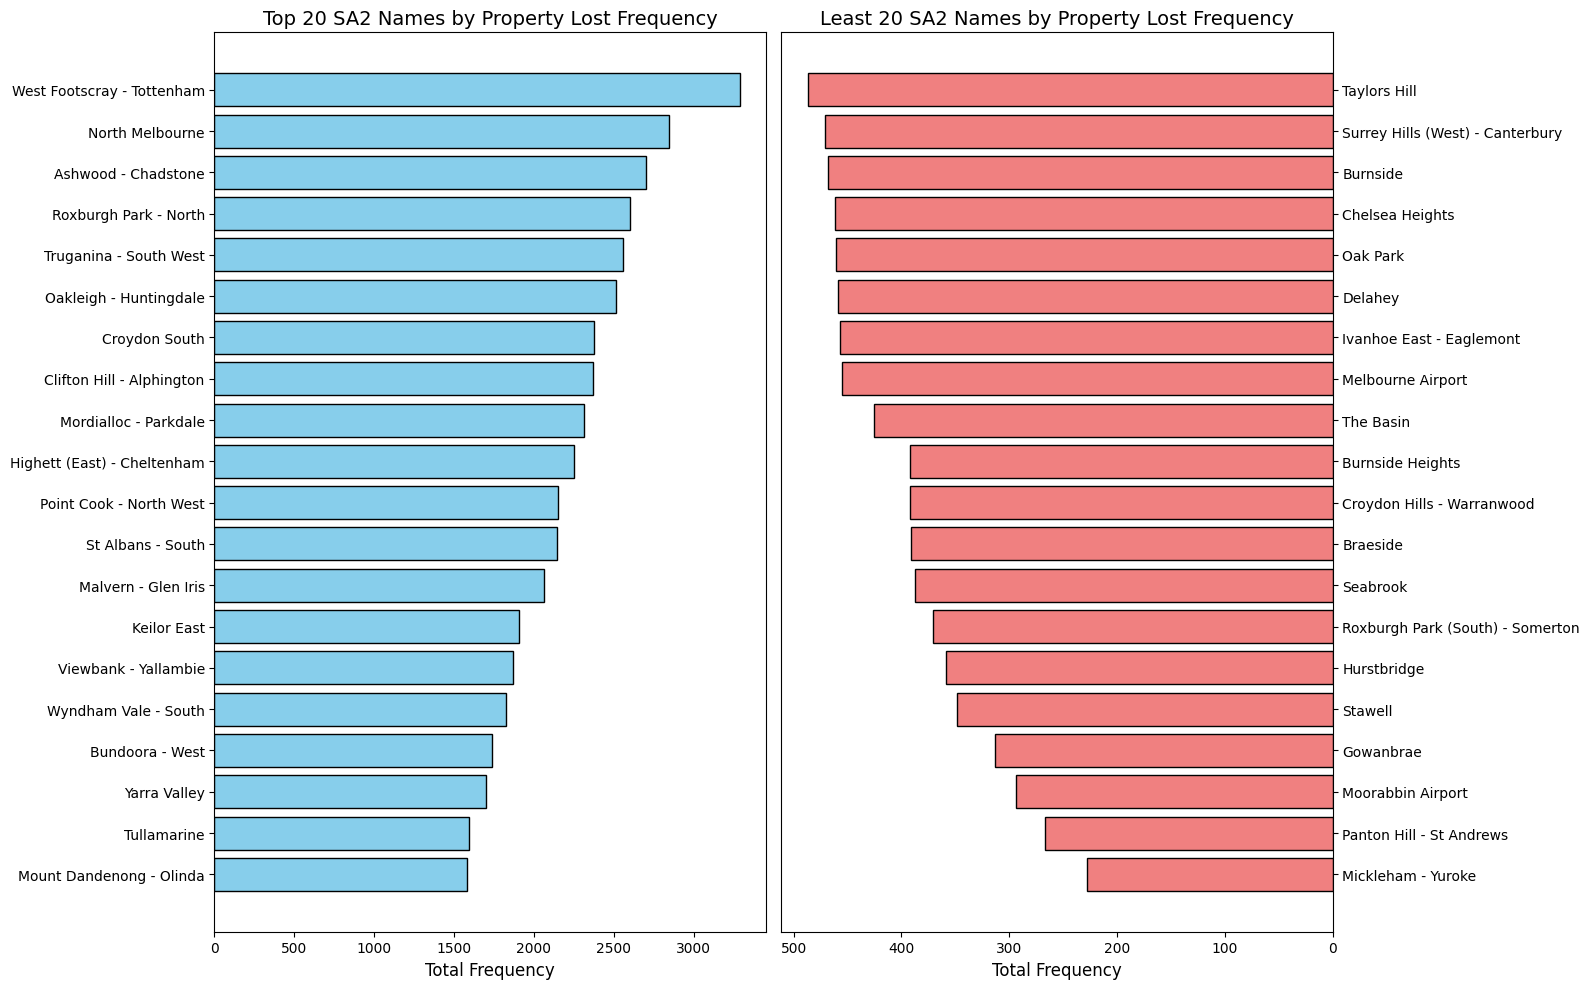

In [33]:
# Group by sa2_name and sum the frequencies of property lost occurrences
property_loss_counts = filtered_postcodes_df.groupby('sa2_name').size().reset_index(name='total_frequency')

# Sort by total frequency
property_loss_counts_sorted = property_loss_counts.sort_values('total_frequency', ascending=False)

# Split the data into top 20 and least 20 by total frequency
top_20 = property_loss_counts_sorted.head(20)
least_20 = property_loss_counts_sorted.tail(20)

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

# Plot for top 20
axes[0].barh(top_20['sa2_name'], top_20['total_frequency'], color='skyblue', edgecolor='black')
axes[0].set_title('Top 20 SA2 Names by Property Lost Frequency', fontsize=14)
axes[0].set_xlabel('Total Frequency', fontsize=12)
axes[0].invert_yaxis()  # Invert y-axis for top-down order

# Plot for least 20, invert the x-axis, and move the y-axis to the right
axes[1].barh(least_20['sa2_name'], least_20['total_frequency'], color='lightcoral', edgecolor='black')
axes[1].set_title('Least 20 SA2 Names by Property Lost Frequency', fontsize=14)
axes[1].set_xlabel('Total Frequency', fontsize=12)
axes[1].invert_yaxis()  # Invert y-axis for top-down order
axes[1].invert_xaxis()  # Invert the x-axis to start from the right
axes[1].yaxis.set_label_position('right')  # Move the y-axis label to the right
axes[1].yaxis.tick_right()  # Move the y-axis ticks to the right

# Adjust layout to ensure no overlap
plt.tight_layout()

# Display the plots
plt.show()